# 5.11: Discussion - Face Detection Based on HoG Features and Binary Classifier

## Required Libraries

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.filters import sobel
from sklearn.svm import SVC


## Step 1: Download all the datasets and testing images

Loaded 13233 positive and 30000 negative patches.
Positive patches reshaped: (13233, 62, 47)
Negative patches reshaped: (30000, 62, 47)


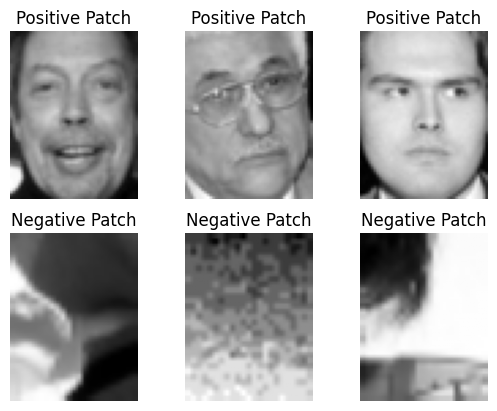

In [17]:
# Load positive and negative image patches from the previous exercise. 
# The patches have the size 62x47 pixels.
# The format of the data is numpy arrays of shape (N, P), where P is the flattened size of each patch (62*47=2914) 
# and N is the number of patches
pos_images = np.load('data/positive_patches.npy')
neg_images = np.load('data/negative_patches.npy')
print(f'Loaded {pos_images.shape[0]} positive and {neg_images.shape[0]} negative patches.')
# Reshape the patches to their original dimensions
# I am trying a different syntax that doesn't loop through each image
# but instead reshapes the entire array at once in memory, so it doesn't need to copy each image individually
# This should be faster and more memory efficient than the list comprehension.
# -1 means the number of images is calculated automatically based on the total size
# cf. https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
pos_images_reshaped = pos_images.reshape((-1, 62, 47))
neg_images_reshaped = neg_images.reshape((-1, 62, 47))
# Print the shapes to verify
print(f'Positive patches reshaped: {pos_images_reshaped.shape}')
print(f'Negative patches reshaped: {neg_images_reshaped.shape}')
# Verify the reshaping by displaying a few patches
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(pos_images_reshaped[i], cmap='gray')
    plt.title('Positive Patch')
    plt.axis('off')
    
    plt.subplot(2, 3, i+4)
    plt.imshow(neg_images_reshaped[i], cmap='gray')
    plt.title('Negative Patch')
    plt.axis('off')
plt.show()

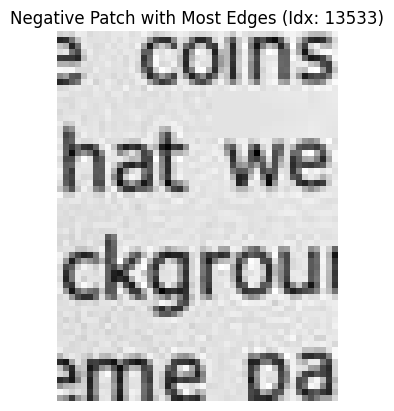

In [18]:
# I want to find "negative" images that are not just blurred background, but have some structure.
# A simple way to do this is to use edge detection (Edges = structures in images).
# I will use the Sobel filter to detect edges in the negative patches.
# The filter computes the gradient magnitude, i.e. the intensity difference for each pixel.
# The idea is that patch with the highest total aggregated intensity differences across the patch should have some structure.
edges = np.array([sobel(img).sum() for img in neg_images_reshaped])
top_index = np.argsort(edges)[-1:]
# Print the patch with highest edge response
plt.imshow(neg_images_reshaped[top_index[0]], cmap='gray')
plt.title(f'Negative Patch with Most Edges (Idx: {top_index[0]})')
plt.axis('off')
plt.show()

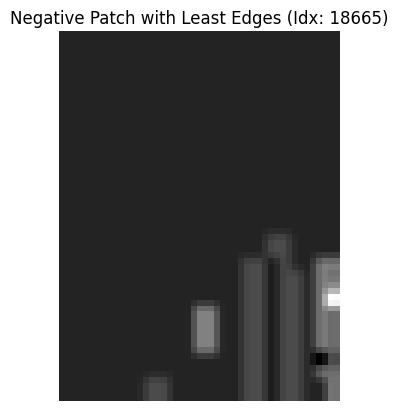

In [19]:
# It turns out a patch with text on it has the highest edge response.
# That makes sense as it is probably originally black on white with a lot of sharp edges.
# Save this patch as an example for non-face with structure.
image_example_structure_no_face = neg_images_reshaped[top_index[0]]

# Also save a patch with background only (lowest edge response)
bottom_index = np.argsort(edges)[:1]
image_example_background = neg_images_reshaped[bottom_index[0]]

plt.imshow(image_example_background, cmap='gray')
plt.title(f'Negative Patch with Least Edges (Idx: {bottom_index[0]})')
plt.axis('off')
plt.show()

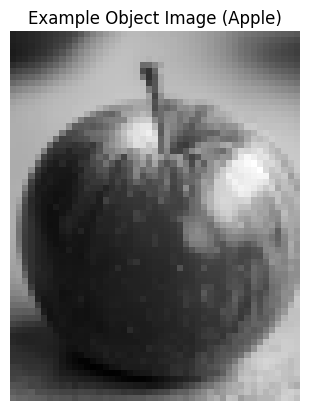

In [31]:
# It would also be nice to have an image of something that is not a face, but is an object. 
# I will reuse the apple image from the previous exercise.
image_example_object = cv2.imread('apple.jpg', cv2.IMREAD_GRAYSCALE)
# Resize to patch size
image_example_object = cv2.resize(image_example_object, (60, 60), interpolation=cv2.INTER_AREA)
image_example_object = image_example_object[:, 6:53]  # 60-47=13 → 6 left, 7 right
plt.imshow(image_example_object, cmap='gray')
plt.title('Example Object Image (Apple)')
plt.axis('off')
plt.show()

## Step 2: HoG Feature

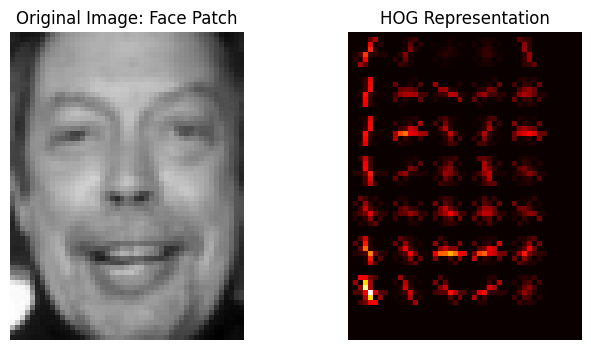

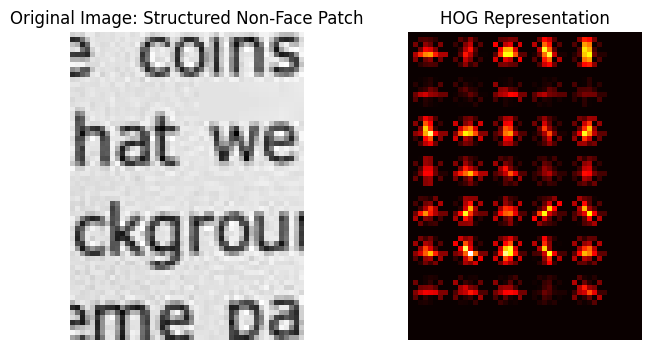

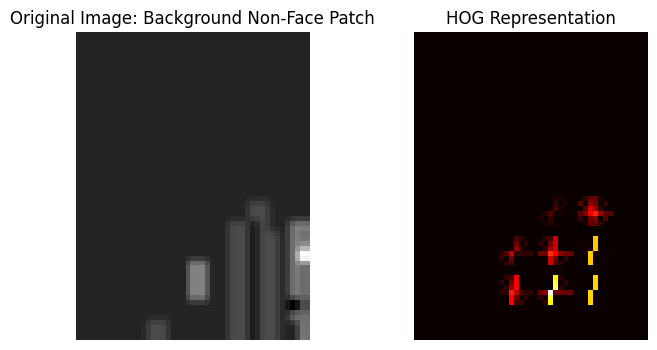

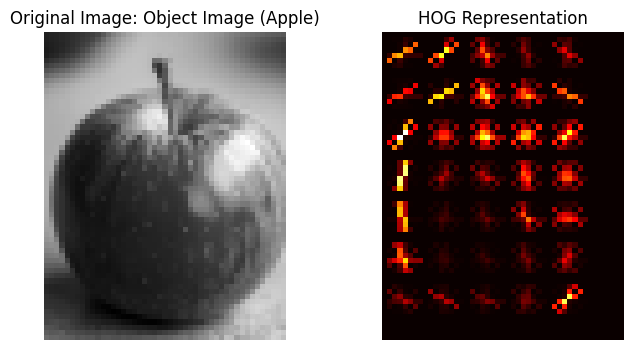

In [32]:
# Create a list of example images
example_images = [
    ('Face Patch', pos_images_reshaped[0]),
    ('Structured Non-Face Patch', image_example_structure_no_face),
    ('Background Non-Face Patch', image_example_background),
    ('Object Image (Apple)', image_example_object)
]

# Calculate and display HOG features for each example image. Display the original image and its HOG representation side by side.
for title, img in example_images:
    hog_features, hog_image = feature.hog(img, pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2),
                                          visualize=True)
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image: {title}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='hot')
    plt.title('HOG Representation')
    plt.axis('off')
    
    plt.show()  